This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below. 

I have simplier model with 
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

# Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [3]:
filenames = os.listdir("C:/Users/Admin/anaconda3/Eduonix_batch1/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0


In [5]:
df.tail()

,filename,category
398,dog.96.jpg,1
399,dog.97.jpg,1
400,dog.98.jpg,1
401,dog.99.jpg,1
402,train,0


### See Total In count

<Axes: xlabel='category'>

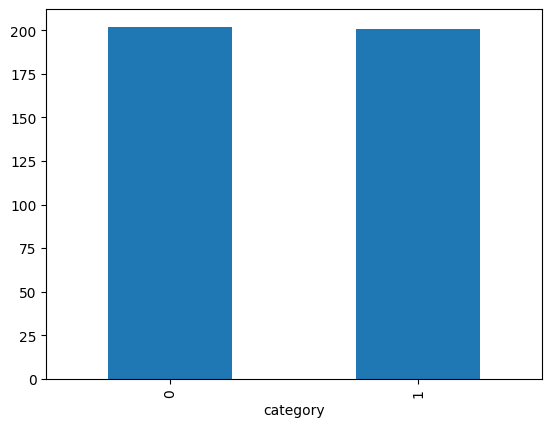

In [6]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

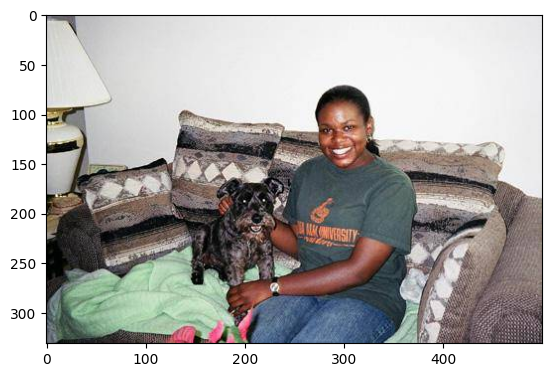

In [7]:
sample = random.choice(filenames)
image = load_img("C:/Users/Admin/anaconda3/Eduonix_batch1/train/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [9]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [10]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

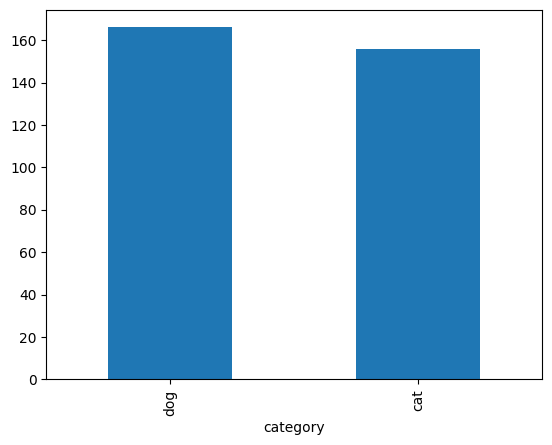

In [12]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

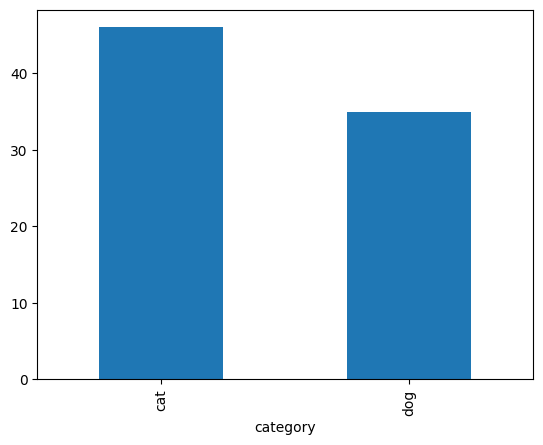

In [13]:
validate_df['category'].value_counts().plot.bar()

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Admin/anaconda3/Eduonix_batch1/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 321 validated image filenames belonging to 2 classes.


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


### Validation Generator

In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/Premalatha/Downloads/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 81 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


# See how our generator work

In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Admin/anaconda3/Eduonix_batch1/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


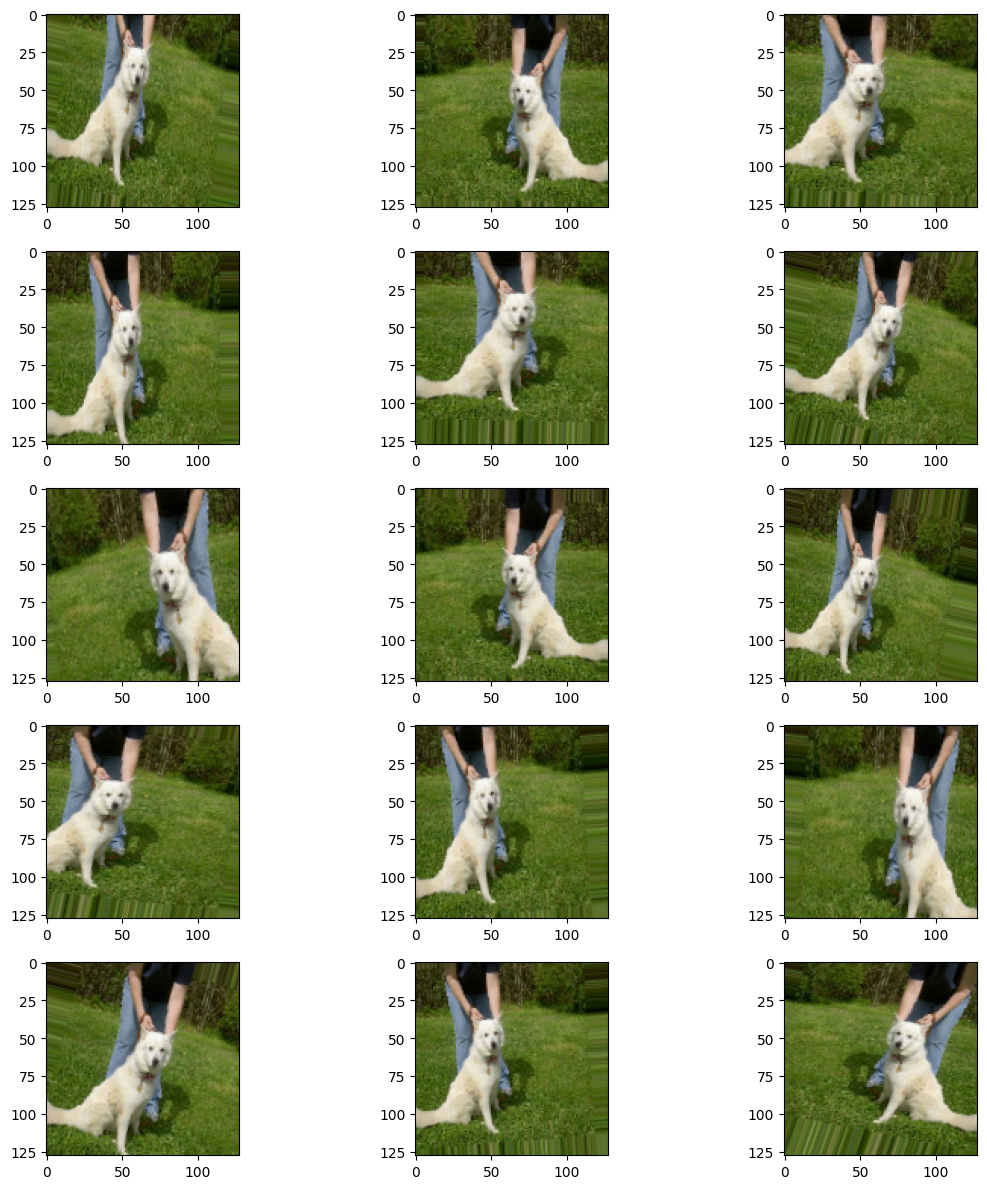

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [19]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("model.h5")

Epoch 1/50
21/21 [==============================] - 14s 570ms/step - loss: 1.6067 - accuracy: 0.5621 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 13s 595ms/step - loss: 1.4184 - accuracy: 0.5359 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 12s 590ms/step - loss: 1.1294 - accuracy: 0.5850 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 12s 573ms/step - loss: 1.0604 - accuracy: 0.6013 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 12s 579ms/step - loss: 0.9808 - accuracy: 0.5882 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 12s 586ms/step - loss: 0.9426 - accuracy: 0.6275 - lr: 0.0010
Epoch 7/50
21/21 [==============================] - 12s 584ms/step - loss: 0.7871 - accuracy: 0.6405 - lr: 0.0010
Epoch 8/50
21/21 [==============================] - 13s 588ms/step - loss: 0.7758 - accuracy: 0.6797 - lr: 0.0010
Epoch 9/50
21/21 [==============================] - 13s 592ms/step - loss: 0.8831 - accu

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualize Training